In [2]:
cd /mnt/sda/otani/Experiments/moment_retrieval

/mnt/sda/otani/Experiments/moment_retrieval


In [7]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from src.toolbox.utils import _nms
from src.toolbox.eval import evaluate, accumulate_metrics, categorize_results, summarize_results_per_class
from src.toolbox.utils import _nms
from src.toolbox.visualization import plot_performance_per_class, plot_performance_per_duration
from src.toolbox.data_converters import CharadesSTA2Instances
import seaborn as sns
import pickle as pkl
import json
import neptune
sns.set_style("white")

In [4]:
# load ground truth test set
test_data = CharadesSTA2Instances(pd.read_csv('data/processed/test.csv'))

In [5]:
project = neptune.init("mayu-ot/moment-retrieval")
exp_id = "MOM-6"
if not os.path.exists(f"tmp/{exp_id}/{exp_id}199.json"):
    exps = project.get_experiments(id=exp_id)
    print("downloading results ...")
    exps[0].download_artifact(f"{exp_id}199.json", f"tmp/{exp_id}")
    print("done!")

downloading results ...
done!


In [20]:
def get_duration(video_id):
    for x in test_data:
        if x[0][0] == video_id:
            return x[1][-1]

def get_evaluation_results(predictions):
    preds = []
    for p in predictions:
        query = (p[0], p[2]+".")
        video_duration = get_duration(query[0])
        seg = [s + [video_duration] for s in p[3][:10]]
        preds.append((query, seg, p[5][:10]))
    results = evaluate(test_data, preds)
    summary = accumulate_metrics(results)
    return results, summary

In [21]:
predictions = json.load(open(f"tmp/{exp_id}/{exp_id}199.json"))
results, summary = get_evaluation_results(predictions)

8 missing instances
missing item: ('U2AO1', 'closes the doors.the person takes the food.')
missing item: ('SVIXG', 'person opening a box.')
missing item: ('SVIXG', 'person eating from a box of food.')
missing item: ('SVIXG', 'person eating something out of it.')
missing item: ('SVIXG', 'person eats a few pieces from inside.')
missing item: ('7JHW2', 'the person puts the laptop down onto a table.')
missing item: ('7JHW2', 'a person runs into the garage.')
missing item: ('7JHW2', 'person holding a laptop.')
missing item: ('7JHW2', 'person sets a laptop computer on a counter.')
R@1 IoU>0.3 0.65
R@1 IoU>0.5 0.52
R@1 IoU>0.7 0.31
R@5 IoU>0.3 0.82
R@5 IoU>0.5 0.73
R@5 IoU>0.7 0.56
R@10 IoU>0.3 0.82
R@10 IoU>0.5 0.73
R@10 IoU>0.7 0.56


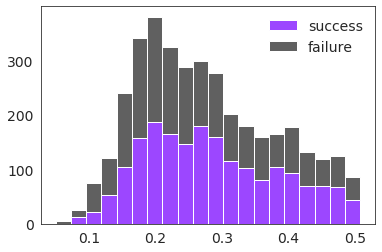

In [23]:
# Check relation between success rates and iput video durations
plt.rcParams.update({'font.size': 14})
fig = plot_performance_per_duration(results, test_data, ax=plt.gca())

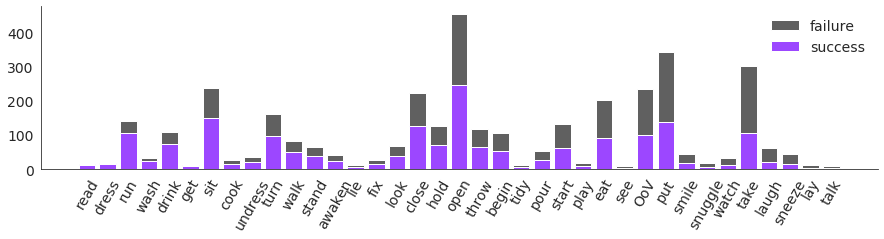

In [24]:
# per-action performance
from src.toolbox.eval import get_first_action, categorize_results, summarize_results_per_class
from src.toolbox.utils import _load_top_actions

top_actions = _load_top_actions("charade")
cat_fn = lambda x: get_first_action(x, top_actions)
categorized_results = categorize_results(results, cat_fn)
metrics_per_cls = summarize_results_per_class(categorized_results)
class_labels = list(metrics_per_cls.keys())
frequent_class = [label for label in class_labels if metrics_per_cls[label]["n_instance"] > 10]
_ = plot_performance_per_class({l: v for l, v in metrics_per_cls.items() if l in frequent_class})